In [1]:
import numpy as np
from cosmoTransitions.tunneling1D import SingleFieldInstanton
from cosmoTransitions import generic_potential_Gegenbauer
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special
import seaborn as sns
from scipy import misc
from scipy.special import gegenbauer
from scipy.special import eval_gegenbauer
from scipy.special import roots_gegenbauer
import math 




%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8, 6)  #set default figure size

label_size=20
thick_size=20



####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18
cs=1/3**0.5 ##Sound speed constant


####This code uses an interpolation function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
gtab = np.loadtxt( 'standardmodel2018.txt' )[::20]
g_star=interpolate.interp1d(gtab[::,0], gtab[::,1], kind='cubic')
g_sstar=interpolate.interp1d(gtab[::,0], gtab[::,3], kind='cubic')


def Hubble_radiation(T):
    """Hubble rate (squared) coming from radiation dof"""
    num_dof=g_star(T)
    Hubble_rad_squared=num_dof*np.pi**2/90*T**4/Mplanck**2
    return Hubble_rad_squared




####MY FUNCTIONS START HERE      

def GBpotential(Ngb,n,z):
    lam=(Ngb-1)/2
    x=np.cos(z)
    return -eval_gegenbauer(n,lam,x)

def GBpotential_roots(Ngb,n):
    """Return the roots of the Gegenbauer polynomial"""
    lam=(Ngb-1)/2
    output=roots_gegenbauer(n,lam)[0]
    return sorted(np.arccos(output[output>0]))
                 

def findGBminima(Ngb,n,roots_list):
    "Find the all minima of the Gegenbauer polynomial between 0 and pi/2"
    fun=lambda z:GBpotential(Ngb,n,z)
    output=[]
    roots_list.insert(0,0)
    for i in range(len(roots_list)):
        if 2*i+1==len(roots_list) or 2*i==len(roots_list):
            break
        solmin=optimize.minimize_scalar(fun,bounds=(roots_list[2*i],roots_list[2*i+1]),method="bounded",options={"disp":False})
        output.append(solmin.x)
    return np.array(output)


def Gamma_S4_v1(vev,action):
    """ This function returns the decay rate for 
    a 4D zero temperature transition taken from formula (4.2) of 1901.11038"""
    return vev**4*(action/2/np.pi)**2*np.exp(-action)

def Gamma_S4_v2(radius,action):
    """ This function returns the decay rate for 
    a 4D zero temperature transition taken from formula (2.1) of 1809.08242"""
    return (1/radius)**4*(action/2/np.pi)**2*np.exp(-action)


def epsilon_bound(f,Mscale,n,Ngb):
    epsilon_max=24*f**2/Mscale**2*16*np.pi**2*Ngb/3
    epsilon_max*=math.factorial(Ngb)
    epsilon_max*=math.factorial(n-1)
    epsilon_max*=1/math.factorial(n+Ngb-1)
    epsilon_max*=1/n
    epsilon_max*=1/(Ngb-1)
    epsilon_max*=1/(Ngb + n - 1)
    return epsilon_max

In [5]:
class model1(generic_potential_Gegenbauer.generic_potential):

    def init(self, Ngb=4, n=20,Mscale=1000,f=1000,epsilon=1e-3):
        self.Ndim = 1
        self.Ngb=Ngb
        self.n=n
        self.f=f
        self.epsilon=epsilon
        self.Mscale=Mscale
        self.const=self.f**2*self.epsilon*self.Mscale**2
        self.findVacua_list()
        self.renormScaleSq = (self.f)**2

    
    def findVacua_list(self):
        """This function finds ALL the minima of the T=0 potential, including the CW piece.
        Stores the list in self.vacua_list"""
        roots=GBpotential_roots(self.Ngb,self.n)
        root_list=findGBminima(self.Ngb,self.n,roots) 
        #min_list=[]
        #for h0 in np.array(root_list)*self.f:
        #    min_list.append(float(self.findMinimum(h0,0)))
        self.vacua_list=np.array(root_list)
        return
    def findVacua_list_old(self):
        """This function finds ALL the minima of the T=0 potential, including the CW piece.
        Stores the list in self.vacua_list"""
        roots=GBpotential_roots(self.Ngb,self.n)
        root_list=findGBminima(self.Ngb,self.n,roots) 
        min_list=[]
        for h0 in np.array(root_list)*self.f:
            min_list.append(float(self.findMinimum(h0,0)))
        self.vacua_list=np.array(min_list)/self.f
        return
 
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0])

    def V0(self, X):
        X = np.asanyarray(X)
        h = X[...]
        z=h/self.f
        pot =self.const*GBpotential(self.Ngb,self.n,z)
        
        return pot
    
    def boson_massSq(self, X, T):
        X = np.asanyarray(X)
        h = X[...,]
        
        ##Determine normalization constant
        #fun=lambda x :self.V0(x)
        #DG=misc.derivative(fun, x0=h,  n=1)
        #D2G=misc.derivative(fun, x0=h, n=2)
        #Mh2=D2G
        #MG2=DG/np.tan(h/self.f)/self.f
        lam=(self.Ngb-1)/2.
        x=h/self.f
        
        Mh2=-np.cos(x)*eval_gegenbauer(self.n-1,lam+1,np.cos(x))
        Mh2+=2*(1+lam)*eval_gegenbauer(self.n-2,lam+2,np.cos(x))*np.sin(x)**2
        Mh2*=2*self.Mscale**2*self.epsilon*lam
        
        MG2=-2*self.Mscale**2*self.epsilon*lam*np.cos(x)*eval_gegenbauer(self.n-1,lam+1,np.cos(x))
        
        M = np.array([Mh2,MG2])
        M = np.rollaxis(M, 0, len(M.shape))

        dof = np.array([1,self.Ngb-1])

        c = np.array([.5,.5])

        return M, dof, c

    
    def plot1(self):
        z_range=np.linspace(0,self.f*np.pi/2,200)

        plt.plot(z_range,self.V0(z_range),label="Tree-level")
        if len(self.vacua_list)==0:
            self.findVacua_list()
        plt.scatter(self.vacua_list*self.f,self.V0(self.f*self.vacua_list))

        plt.xlabel("$\Pi$ [GeV]",size=label_size)
        plt.ylabel("$G$",size=label_size)
        plt.legend()
        plt.legend(prop={'size': label_size})
        plt.xticks(fontsize=thick_size)
        plt.yticks(fontsize=thick_size)
        plt.grid(True)
        #mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
        #plt.title(mytitle,size=label_size)
        plt.tight_layout()
        #plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
        #plt.show()
        
    
    def approxZeroTMin(self):
        if self.vacua_list==[]:
            self.findVacua_list()
        return list(self.vacua_list*self.f)

        
  
def find_Bubble(Ngb_val,n_val,f_val):
    """This function does the whole pipeline computation and return the approximations for the 
    buble radius,  the bounce action S4, the decay rates Gamma and Hmin^2"""
    Mscale_val=4*np.pi*f_val
    epsilon_val=epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)
    m=model1(Ngb=Ngb_val, n=n_val,Mscale=Mscale_val,f=f_val,epsilon=epsilon_val*1e-2)
    
    phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0:2]
    instanton=SingleFieldInstanton(phi_absMin, phi_metaMin,m.V0,alpha=3 )
    
    profile=instanton.findProfile()
    phi_fun=interpolate.interp1d(profile.R,profile.Phi)
    R0=optimize.root_scalar(lambda x: phi_fun(x)-(phi_absMin+ phi_metaMin)/2.,bracket=(profile.R[0], profile.R[-1])).root
    S4=instanton.findAction(profile)
    Hmin2=(m.V0(phi_metaMin)-m.V0(phi_absMin))/3/Mplanck**2

    r, phi, dphi = profile.R, profile.Phi, profile.dPhi
    # Find the area of an n-sphere (alpha=n):
    d = instanton.alpha+1  # Number of dimensions in the integration
    area = r**instanton.alpha * 2*np.pi**(d*.5)/special.gamma(d*.5)
    # And integrate the profile
    integrand =   m.V0(phi) - m.V0(phi_metaMin)
    integrand *= area
    E0V = integrate.simps(integrand, r)
    # Find the bulk term in the bubble interior
    volume = r[0]**d * np.pi**(d*.5)/special.gamma(d*.5 + 1)
    E0V += volume * (m.V0(phi[0]) - m.V0(phi_metaMin))
    R0_2=(3/4/np.pi*E0V/(m.V0(phi_absMin)-m.V0(phi_metaMin)))**(1/3) ##Estimate from formula (2.23) of 1903.09642 
    
    return R0,R0_2, S4, Gamma_S4_v2(R0,S4), Gamma_S4_v2(R0_2,S4),Hmin2

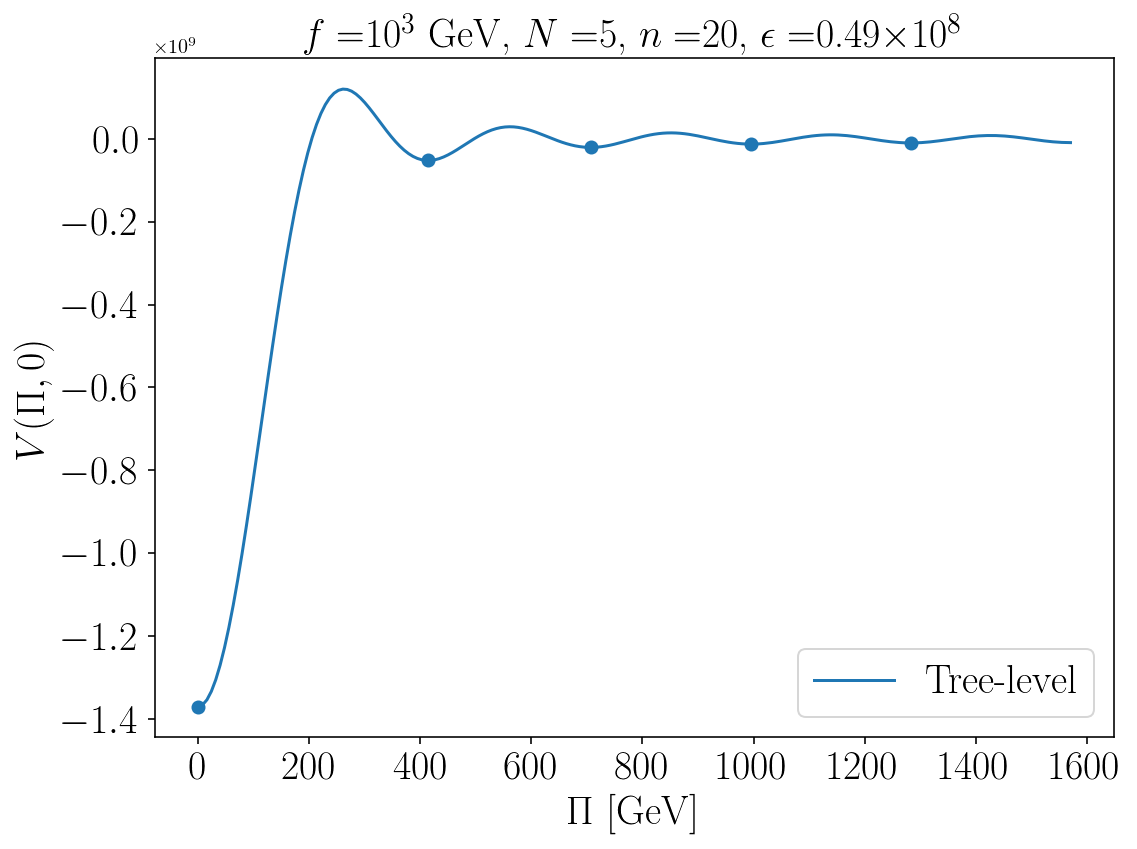

In [122]:
Ngb_val=5
n_val=20
f_val=1000
Mscale_val=4*np.pi*f_val
epsilon_val=epsilon_bound(f_val,Mscale_val,n_val,Ngb_val)

m=model1(Ngb=Ngb_val, n=n_val,Mscale=Mscale_val,f=f_val,epsilon=epsilon_val*1e-2)
m.plot1()

#plt.xlabel("$T$[GeV]",size=label_size)
plt.ylabel("$V(\\Pi,0)$",size=label_size)
#plt.legend(loc="best",prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.grid(False)
plt.title("$f=$"+"$10^{"+str(round(np.log10(m.f)))+"}$"+" GeV"+ ", $N=$"+str(m.Ngb)+
          ", $n=$"+str(m.n)+", $\epsilon=$"+str(round(m.epsilon*10**(-np.round(np.log10(m.epsilon))),2))
          +"$\\times 10^{"+str(-int(np.round(np.log10(m.epsilon))))+"}$",size=label_size)
plt.tight_layout()
plt.savefig('./PLOTS/Dark_Sector/inverted_potential.pdf', dpi=300)

In [7]:
phi_absMin,phi_metaMin = (m.vacua_list*m.f)[0:2]
#phi_absMin,phi_metaMin = (m.vacua_list*m.f)[-2], (m.vacua_list*m.f)[-1]
instanton=SingleFieldInstanton(phi_absMin, phi_metaMin,m.V0,alpha=3 )
profile=instanton.findProfile()

phi_fun=interpolate.interp1d(profile.R,profile.Phi)
R0=optimize.root_scalar(lambda x: phi_fun(x)-(phi_absMin+ phi_metaMin)/2.,bracket=(profile.R[0], profile.R[-1])).root
S4=instanton.findAction(profile)
Hmin2=(m.V0(phi_metaMin)-m.V0(phi_absMin))/3/Mplanck**2

r, phi, dphi = profile.R, profile.Phi, profile.dPhi
# Find the area of an n-sphere (alpha=n):
d = instanton.alpha+1  # Number of dimensions in the integration
area = r**instanton.alpha * 2*np.pi**(d*.5)/special.gamma(d*.5)
# And integrate the profile
integrand =   m.V0(phi) - m.V0(phi_metaMin)
integrand *= area
E0V = integrate.simps(integrand, r)
# Find the bulk term in the bubble interior
volume = r[0]**d * np.pi**(d*.5)/special.gamma(d*.5 + 1)
E0V += volume * (m.V0(phi[0]) - m.V0(phi_metaMin))
R0_2=(3/4/np.pi*E0V/(m.V0(phi_absMin)-m.V0(phi_metaMin)))**(1/3) ##Estimate from formula (2.23) of 1903.09642 


R0,R0_2, S4


(0.021125816050942922, 0.0043270939364498835, 449.9974156381772)

In [158]:
Gamma_S4_v2(R0,S4)/Hmin2**2,Gamma_S4_v2(R0_2,S4)/Hmin2**2

(1.013856688410666e+40, 1.1189666512009534e+31)

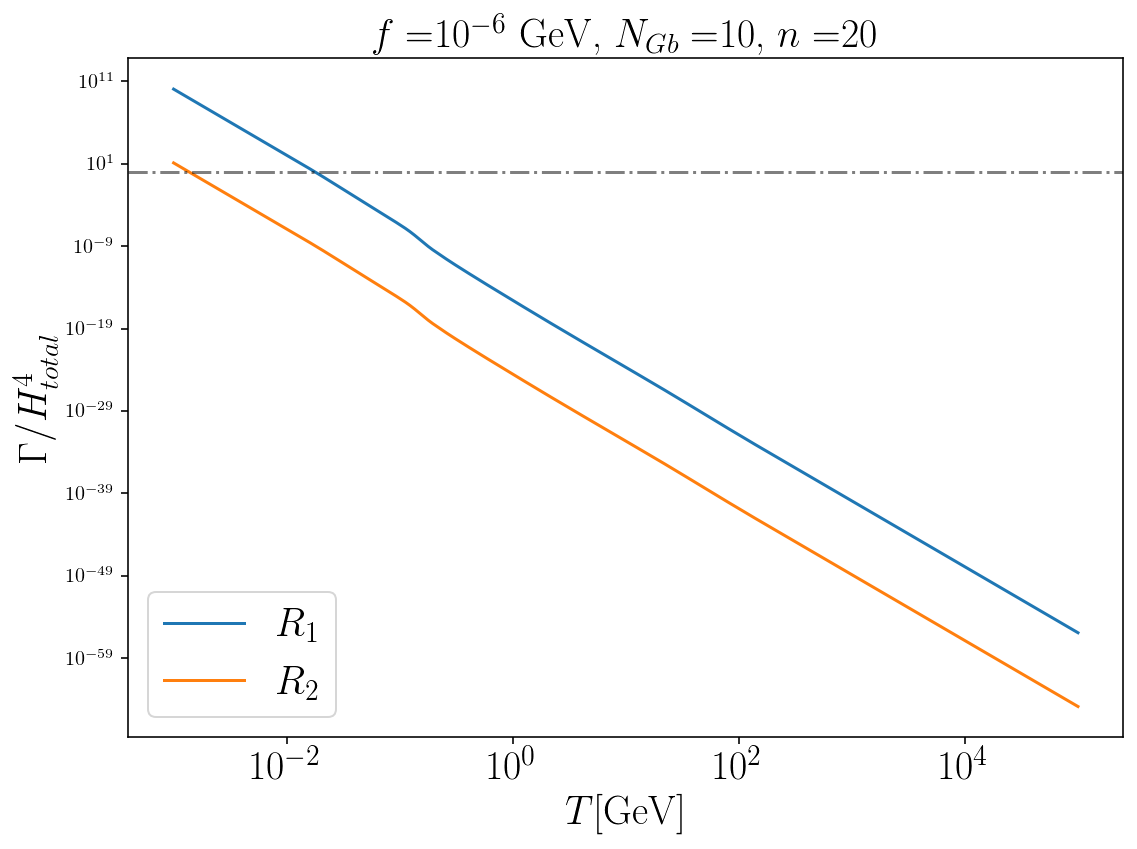

In [159]:
T_range=np.logspace(-3,5,200)
Gamma_full_1=[Gamma_S4_v2(R0,S4)/(Hmin2**2+Hubble_radiation(Tval)**2) for Tval in T_range]
Gamma_full_2=[Gamma_S4_v2(R0_2,S4)/(Hmin2**2+Hubble_radiation(Tval)**2) for Tval in T_range]

plt.plot(T_range,Gamma_full_1,label="$R_1$")
plt.plot(T_range,Gamma_full_2,label="$R_2$")
plt.axhline(y=1,linestyle="dashdot",color="k",alpha=.5)

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$T$[GeV]",size=label_size)
plt.ylabel("$\\Gamma/H_{total}^4$",size=label_size)
plt.legend(loc="best",prop={'size': label_size})
plt.xticks(fontsize=thick_size)
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+ ", $N_{Gb}=$"+str(Ngb_val)+", $n=$"+str(n_val) ,size=label_size)
plt.tight_layout()
plt.show()


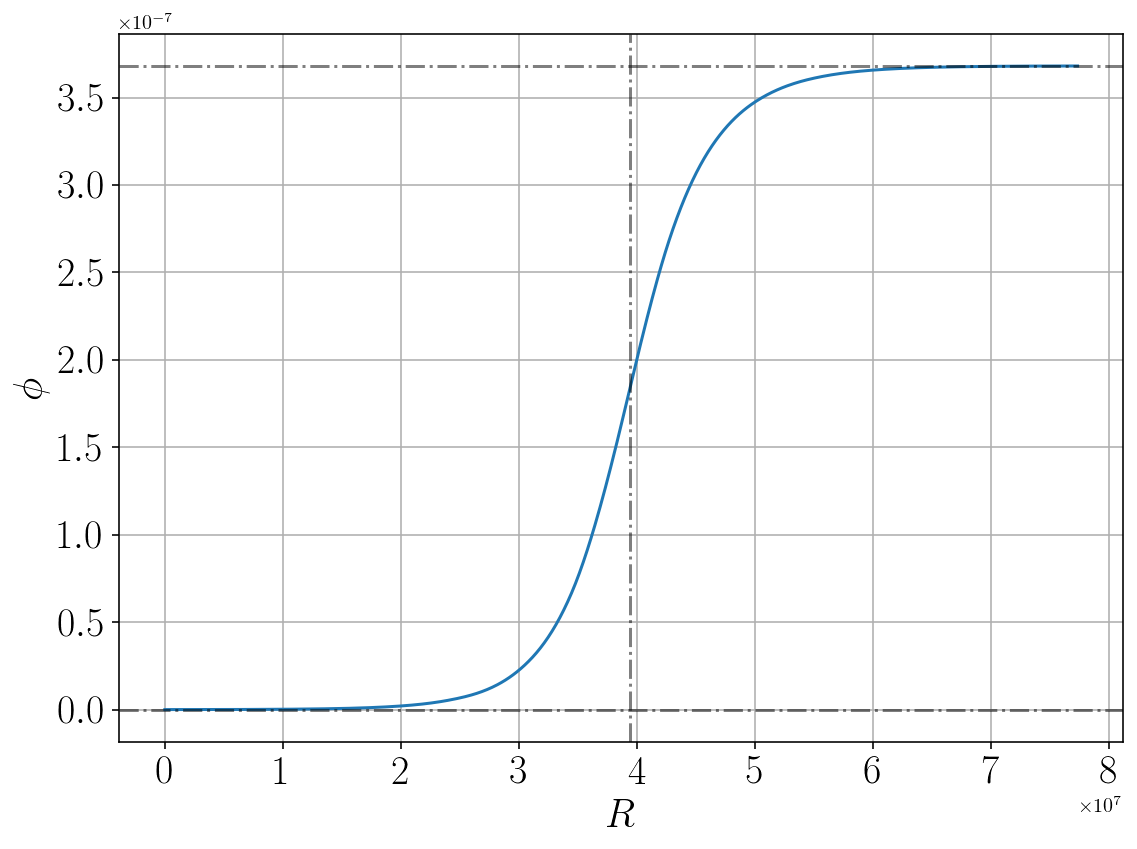

In [150]:
plt.plot(profile.R,profile.Phi)
plt.axhline(y=phi_absMin,linestyle="dashdot",color="k",alpha=.5)
plt.axhline(y=phi_metaMin,linestyle="dashdot",color="k",alpha=.5)

plt.axvline(x=R0,linestyle="dashdot",color="k",alpha=.5)


plt.ylabel("$\phi$ ",size=label_size)
plt.xlabel("$R$",size=label_size)
#plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
#mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
#plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
#plt.show()

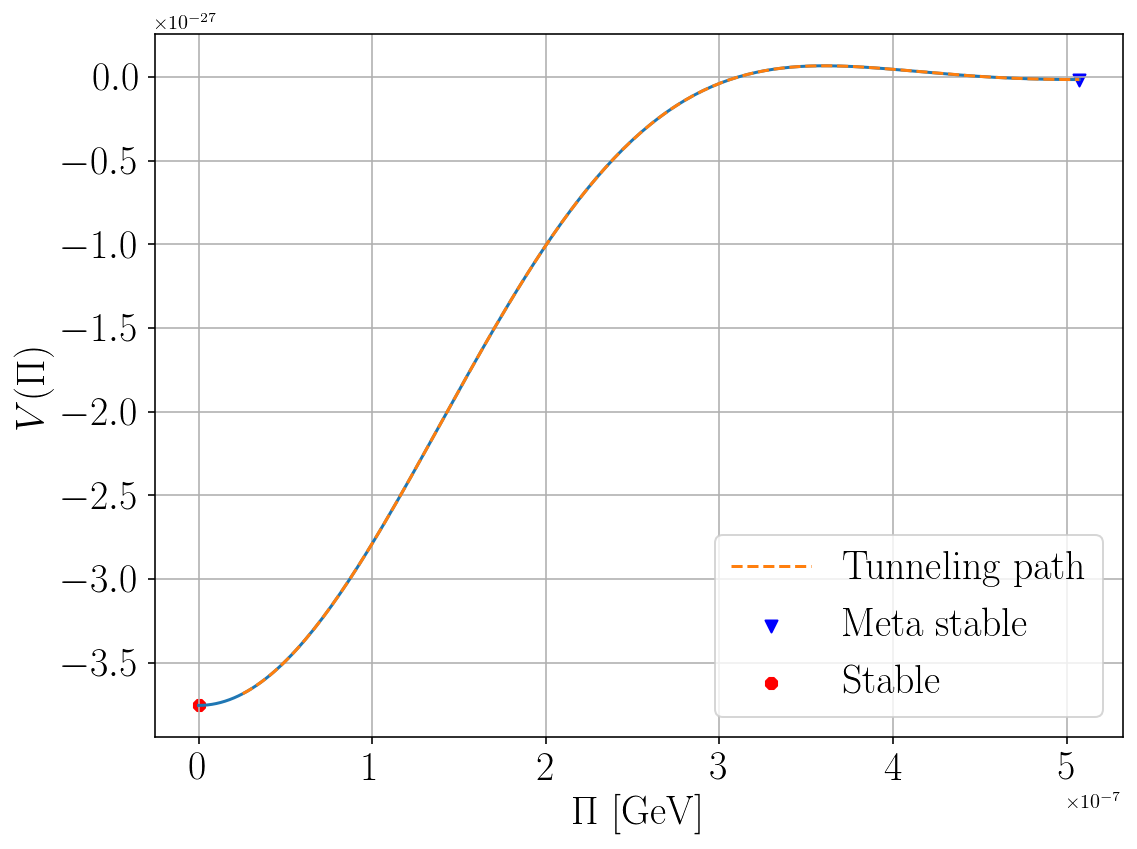

In [145]:
z_range=np.linspace(0,(m.vacua_list*m.f)[1],200)

plt.plot(z_range,m.V0(z_range))

plt.scatter(phi_metaMin,m.V0(phi_metaMin),label="Meta stable",color="b",marker="v")
plt.scatter(phi_absMin,m.V0(phi_absMin),label="Stable",color="r",marker="8")

plt.plot(profile.Phi,m.V0(profile.Phi),label="Tunneling path",ls="--")


plt.xlabel("$\Pi$ [GeV]",size=label_size)
plt.ylabel("$V(\Pi)$",size=label_size)
plt.legend()
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
#mytitle=str(round(df_full.lams.min(),2))+"$< \\lambda_{s} <$"+str(round(df_full.lams.max(),2))
#plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
#plt.show()

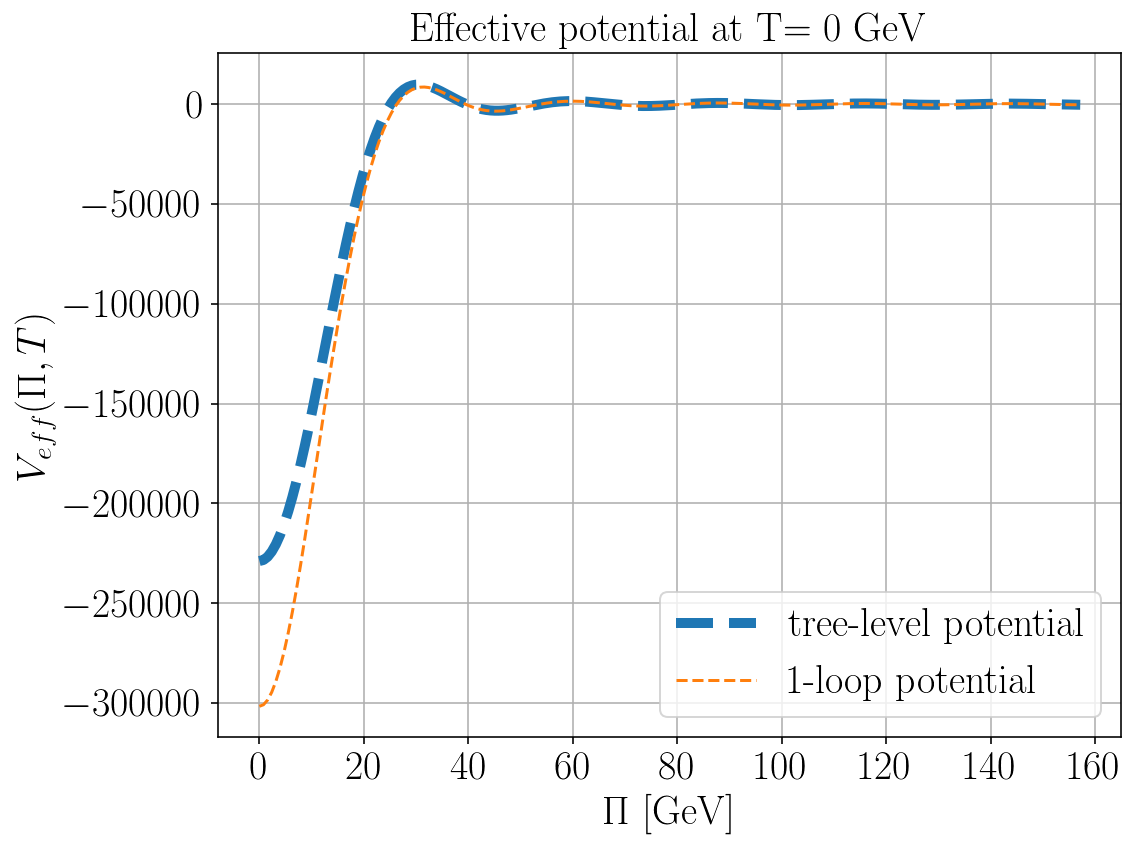

In [110]:
#def plot2(self,T):
T=0*m.f
z_range=np.linspace(1e-6,m.f*np.pi/2,200)
plt.plot(z_range,m.V0(z_range),"--",linewidth=5,label="tree-level potential")
plt.plot(z_range,m.Vtot(z_range,T),"--",label="1-loop potential")
#plt.xlim(0,phi_metaMin)    
plt.legend()
plt.legend(prop={'size': label_size})
plt.xlabel("$\Pi$ [GeV]",size=label_size)
plt.ylabel("$V_{eff}(\Pi,T)$",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
plt.grid(True)
mytitle="Effective potential at T= "+str(np.round(T,1))+" GeV"
plt.title(mytitle,size=label_size)
plt.tight_layout()
#plt.savefig('./LISA_SCANS_1/CLUSTER/PLOTS/lagrangian_params_marginalized.pdf', dpi=300)
#plt.show()

## Let's explote the general behavior

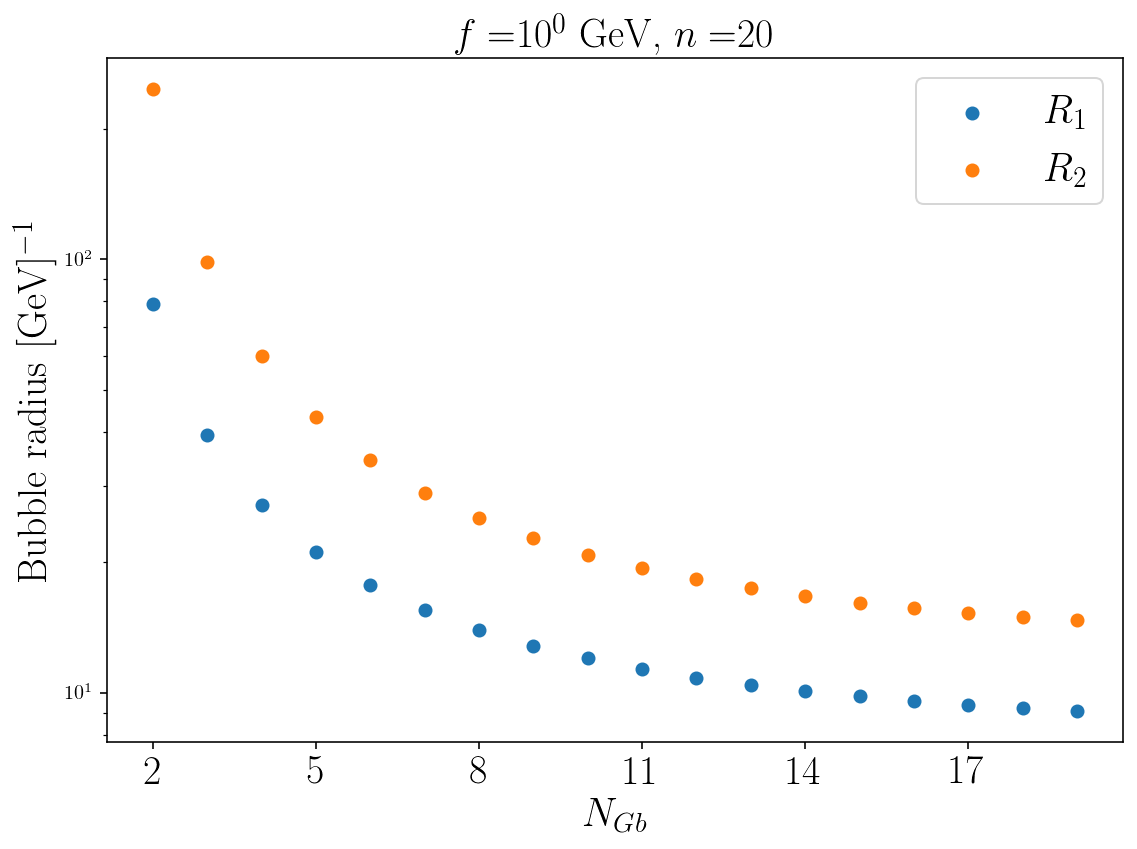

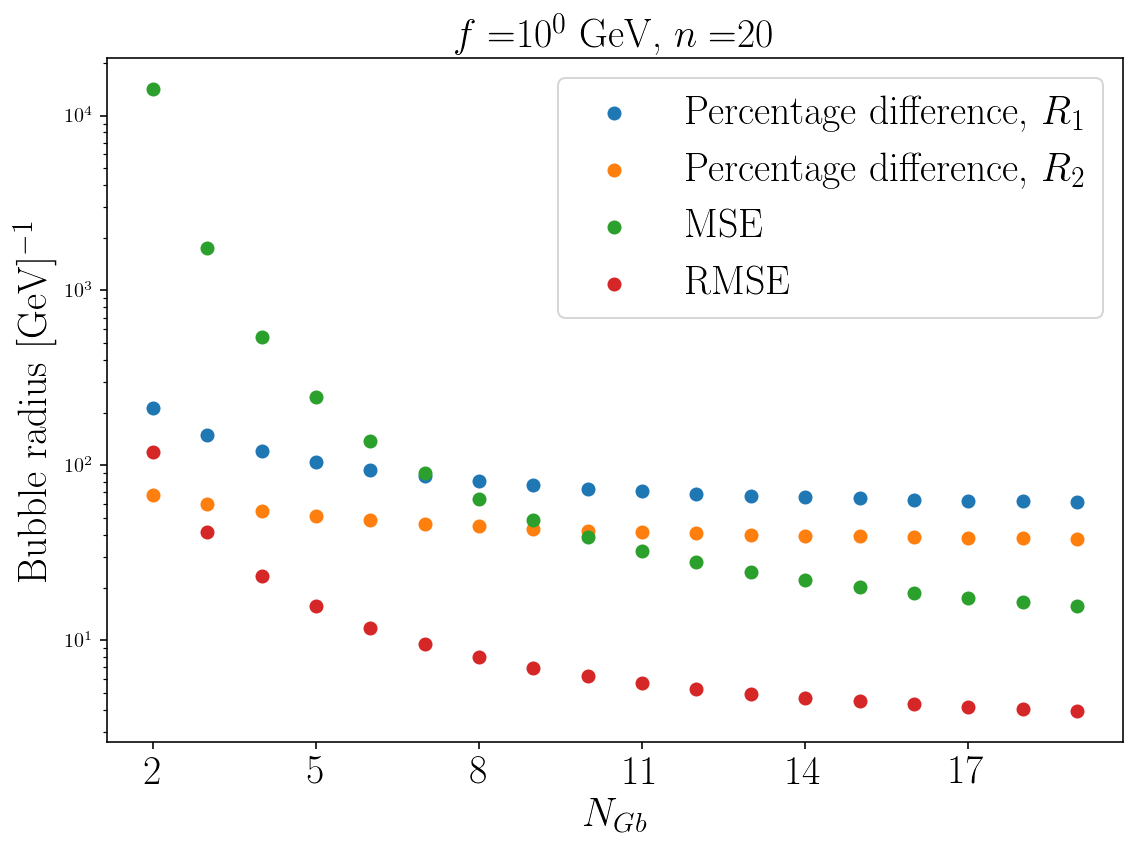

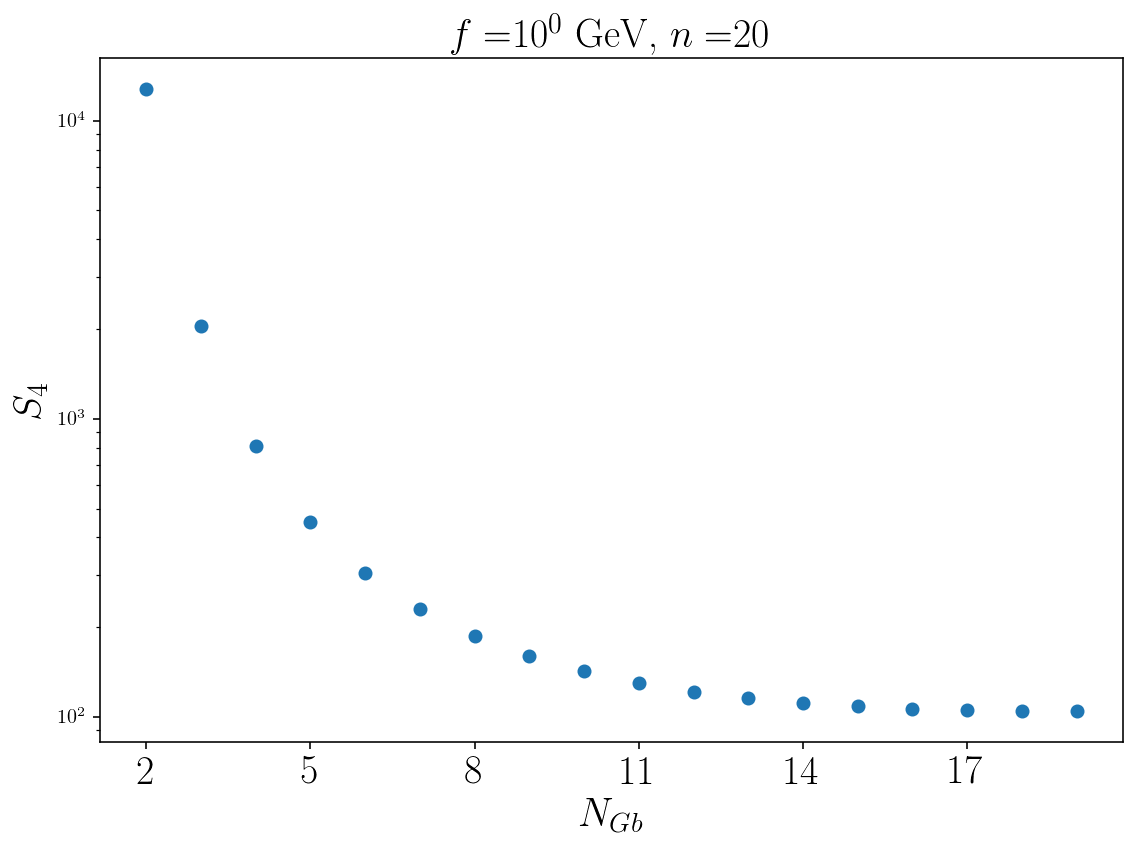

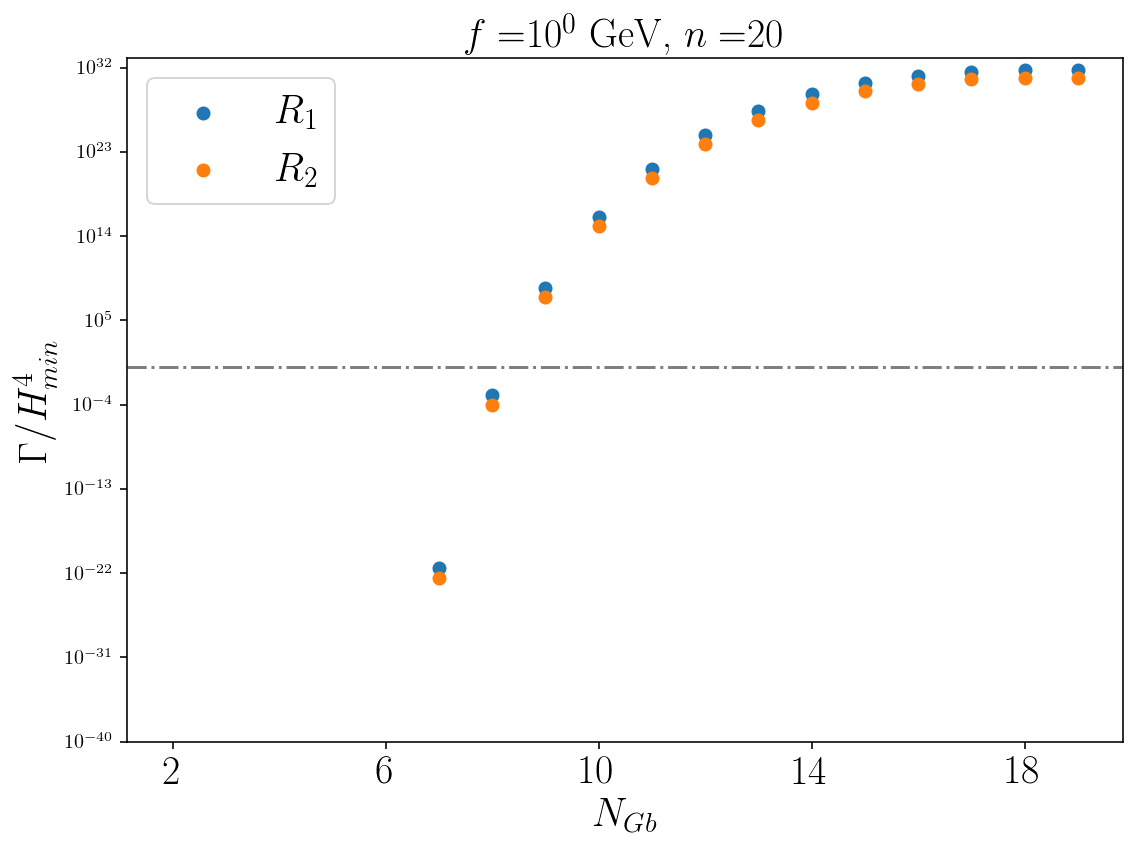

In [151]:
#Ngb_val=2
n_val=20
f_val=1
N_range=np.arange(2,20)

results=[]
for N_val in N_range:
    results.append(find_Bubble(N_val,n_val,f_val))
    
plt.scatter(N_range,np.array(results).T[0],label="$R_1$")
plt.scatter(N_range,np.array(results).T[1],label="$R_2$")
plt.yscale("log")
plt.xlabel("$N_{Gb}$",size=label_size)
plt.ylabel("Bubble radius [GeV]$^{-1}$",size=label_size)
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=N_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $n=$"+str(n_val) ,size=label_size)
plt.tight_layout()
plt.show()


plt.scatter(N_range,abs((np.array(results).T[0]-np.array(results).T[1])/np.array(results).T[0])*100,label="Percentage difference, $R_1$")
plt.scatter(N_range,abs((np.array(results).T[0]-np.array(results).T[1])/np.array(results).T[1])*100,label="Percentage difference, $R_2$")
plt.scatter(N_range,(np.array(results).T[0]-np.array(results).T[1])**2/2,label="MSE")
plt.scatter(N_range,np.sqrt((np.array(results).T[0]-np.array(results).T[1])**2/2),label="RMSE")
plt.yscale("log")
plt.xlabel("$N_{Gb}$",size=label_size)
plt.ylabel("Bubble radius [GeV]$^{-1}$",size=label_size)
plt.legend(loc="best",prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=N_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $n=$"+str(n_val) ,size=label_size)
plt.tight_layout()
plt.show()


plt.scatter(N_range,np.array(results).T[2])
plt.yscale("log")
plt.xlabel("$N_{Gb}$",size=label_size)
plt.ylabel("$S_4$",size=label_size)
#plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=N_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $n=$"+str(n_val) ,size=label_size)
plt.tight_layout()
plt.show()



plt.scatter(N_range,np.array(results).T[3]/np.array(results).T[5]**2,label="$R_1$")
plt.scatter(N_range,np.array(results).T[4]/np.array(results).T[5]**2,label="$R_2$")
plt.axhline(y=1,linestyle="dashdot",color="k",alpha=.5)
plt.yscale("log")
plt.ylim(1e-40,1e33)
plt.xlabel("$N_{Gb}$",size=label_size)
plt.ylabel("$\\Gamma/H_{min}^4$",size=label_size)
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=N_range[0::4])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $n=$"+str(n_val) ,size=label_size)
plt.tight_layout()
plt.show()


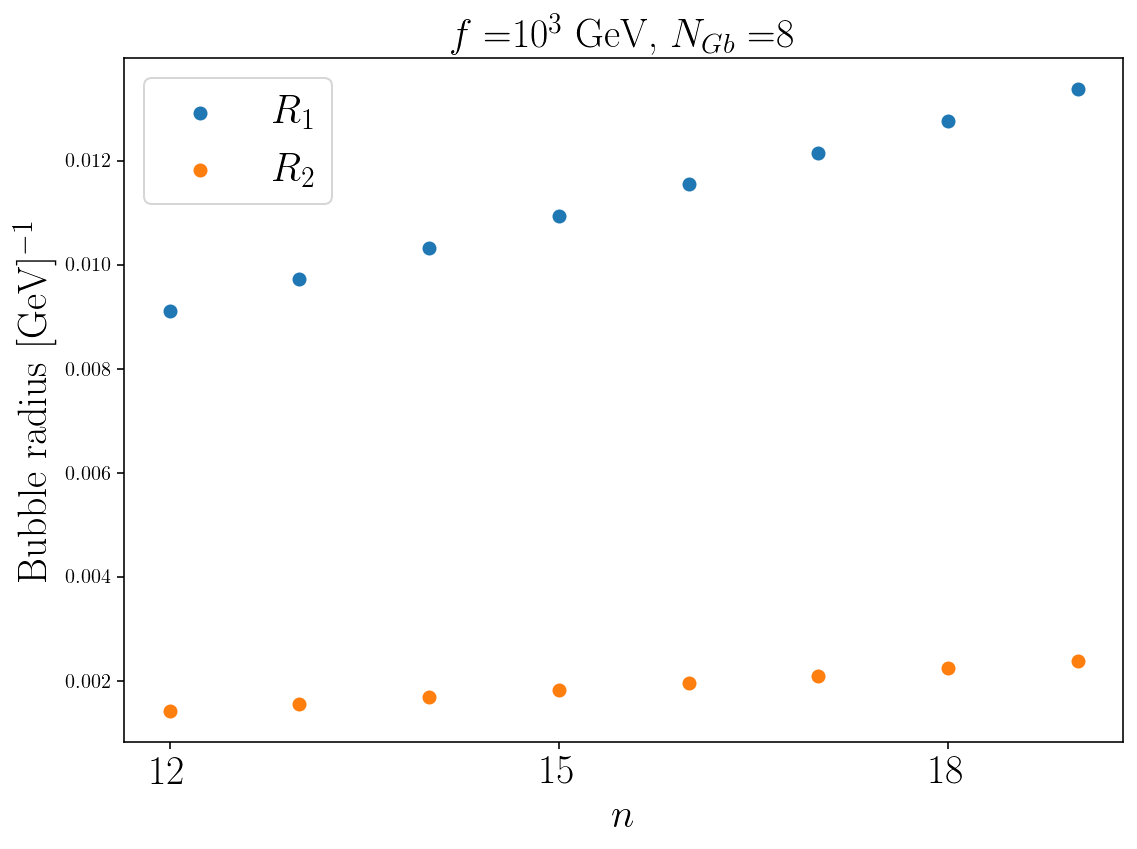

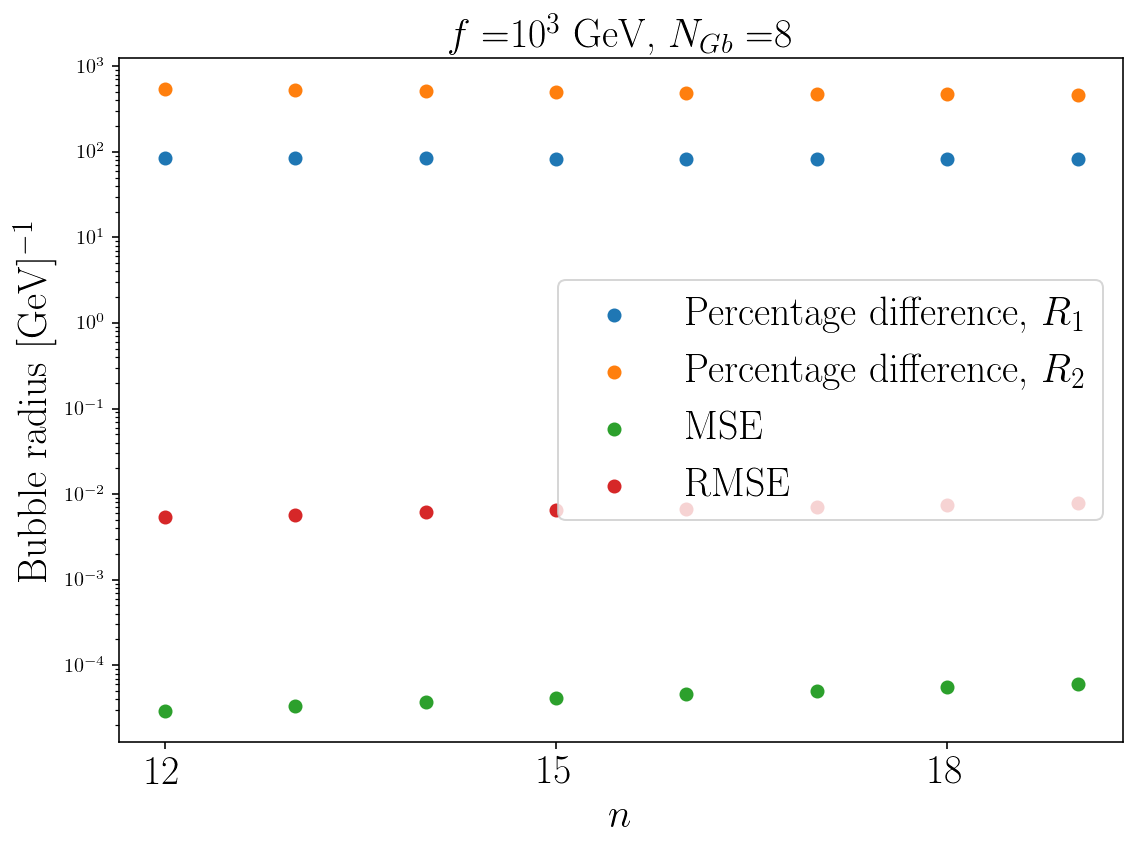

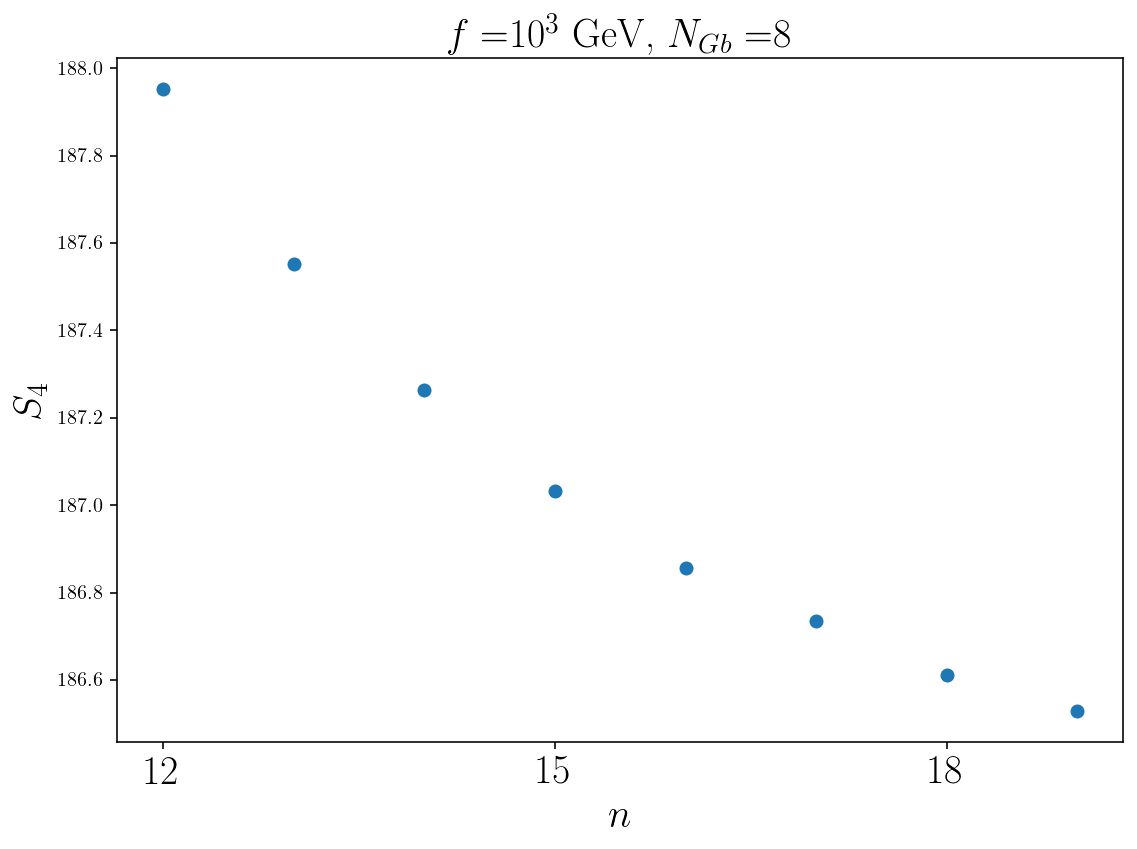

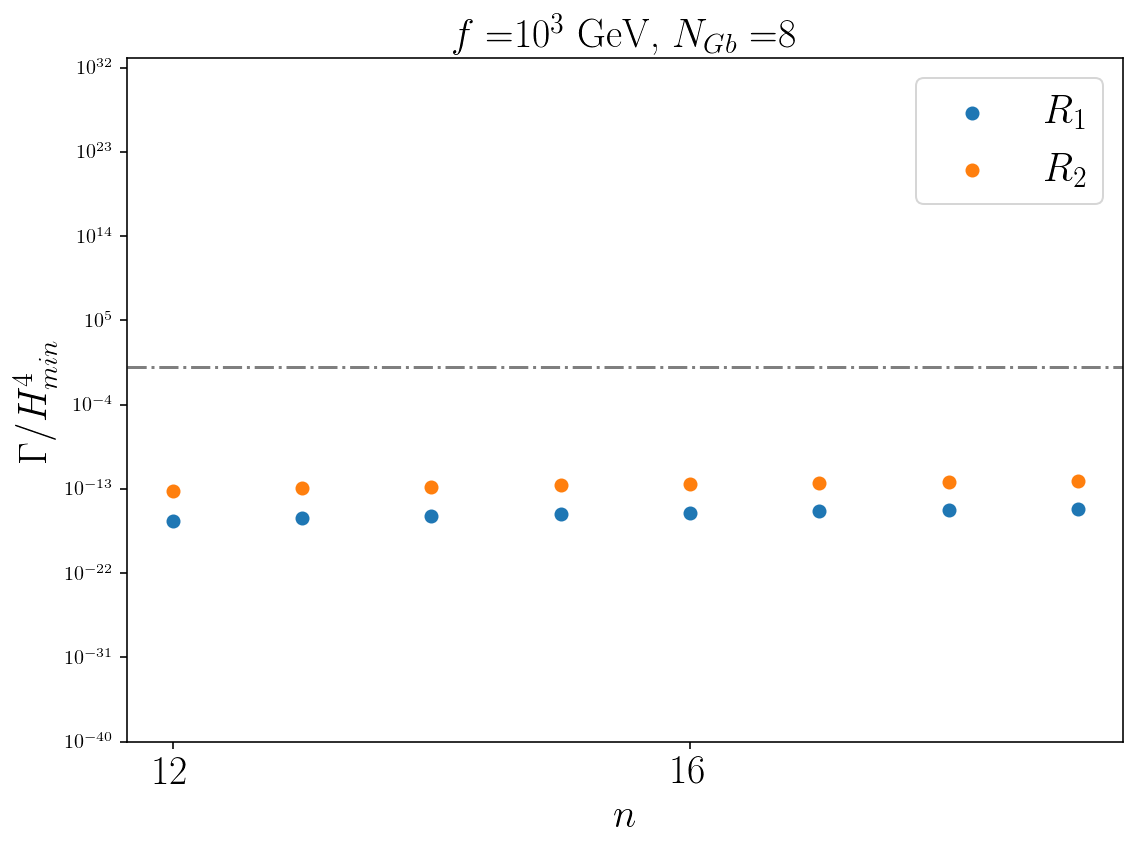

In [97]:
Ngb_val=8
#n_val=20
f_val=1000
n_range=np.arange(12,20)

results=[]
for n_val in n_range:
    results.append(find_Bubble(Ngb_val,n_val,f_val))
    
plt.scatter(n_range,np.array(results).T[0],label="$R_1$")
plt.scatter(n_range,np.array(results).T[1],label="$R_2$")
#plt.yscale("log")
plt.xlabel("$n$",size=label_size)
plt.ylabel("Bubble radius [GeV]$^{-1}$",size=label_size)
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=n_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()

plt.scatter(n_range,abs((np.array(results).T[0]-np.array(results).T[1])/np.array(results).T[0])*100,label="Percentage difference, $R_1$")
plt.scatter(n_range,abs((np.array(results).T[0]-np.array(results).T[1])/np.array(results).T[1])*100,label="Percentage difference, $R_2$")
plt.scatter(n_range,(np.array(results).T[0]-np.array(results).T[1])**2/2,label="MSE")
plt.scatter(n_range,np.sqrt((np.array(results).T[0]-np.array(results).T[1])**2/2),label="RMSE")
plt.yscale("log")
plt.xlabel("$n$",size=label_size)
plt.ylabel("Bubble radius [GeV]$^{-1}$",size=label_size)
plt.legend(loc="best",prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=n_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()


plt.scatter(n_range,np.array(results).T[2])
#plt.yscale("log")
plt.xlabel("$n$",size=label_size)
plt.ylabel("$S_4$",size=label_size)
#plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=n_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()

plt.scatter(n_range,np.array(results).T[3]/np.array(results).T[5]**2,label="$R_1$")
plt.scatter(n_range,np.array(results).T[4]/np.array(results).T[5]**2,label="$R_2$")
plt.axhline(y=1,linestyle="dashdot",color="k",alpha=.5)
plt.yscale("log")
plt.ylim(1e-40,1e33)
plt.xlabel("$n$",size=label_size)
plt.ylabel("$\\Gamma/H_{min}^4$",size=label_size)
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size,ticks=n_range[0::4])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$f=$"+"$10^{"+str(round(np.log10(f_val)))+"}$"+" GeV"+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()

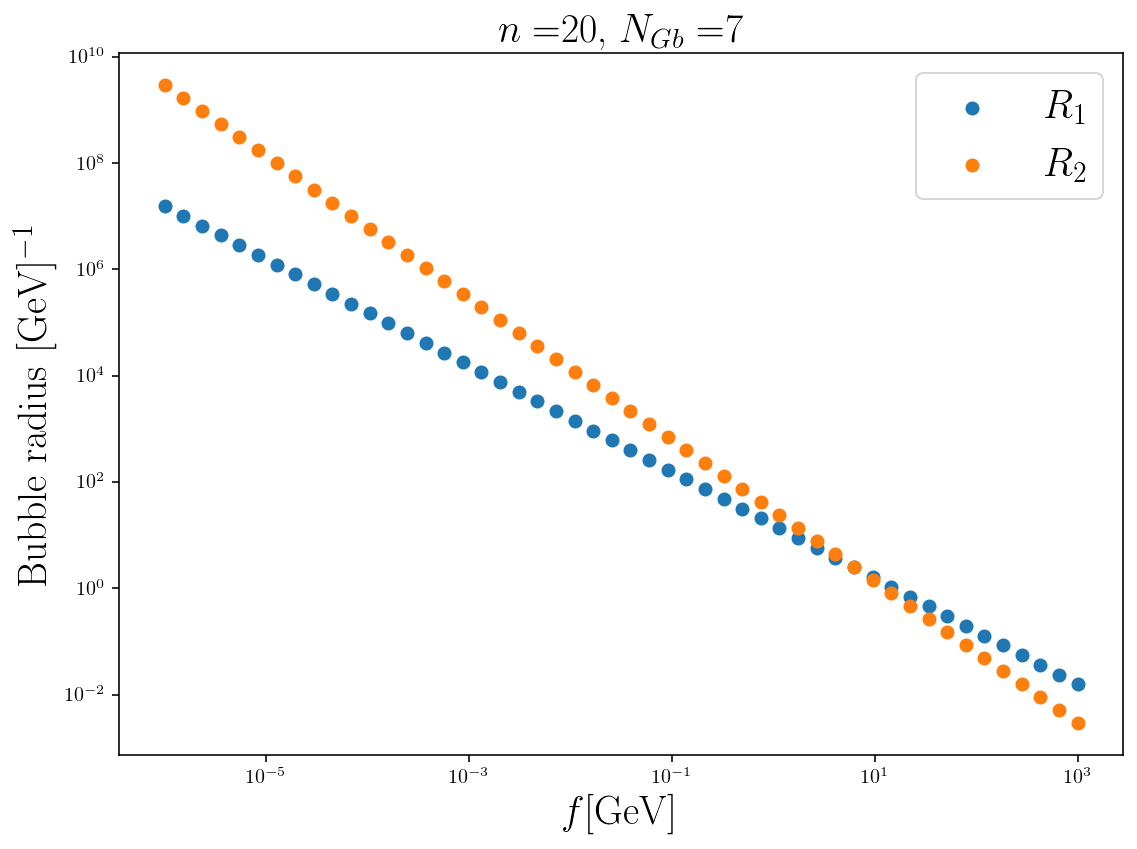

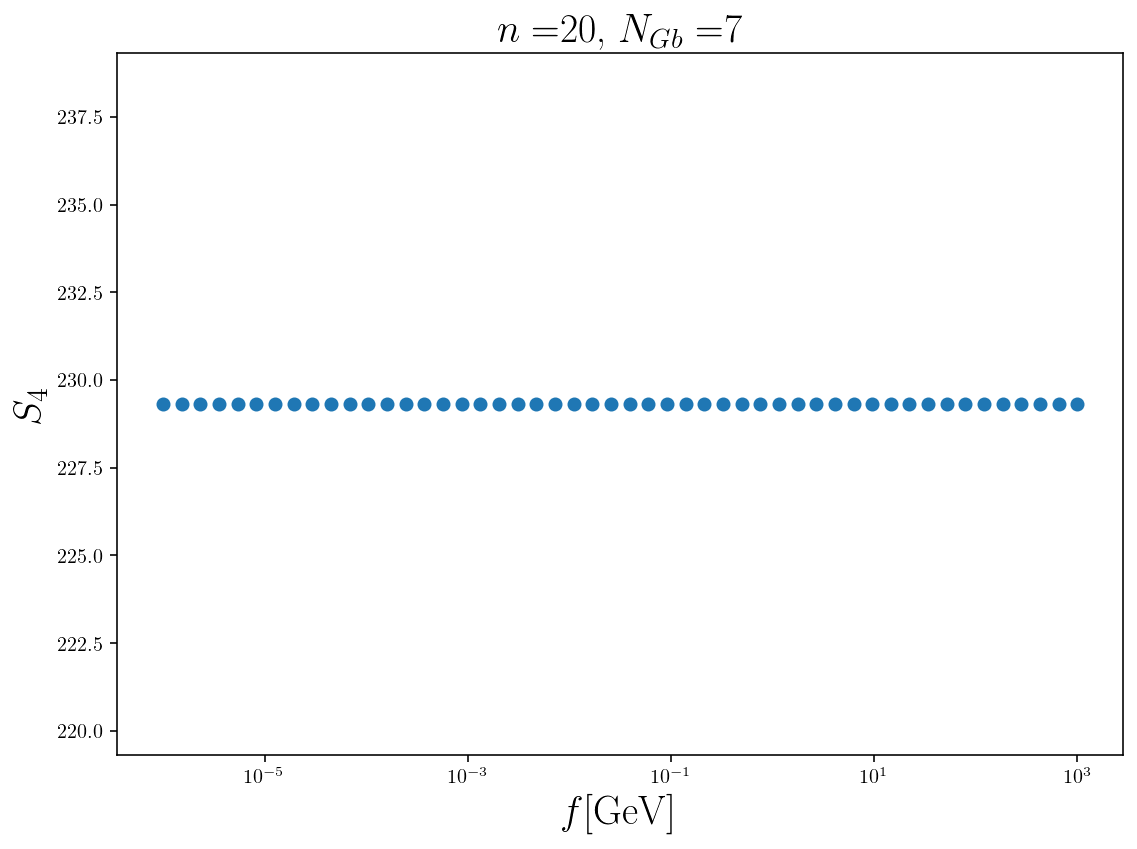

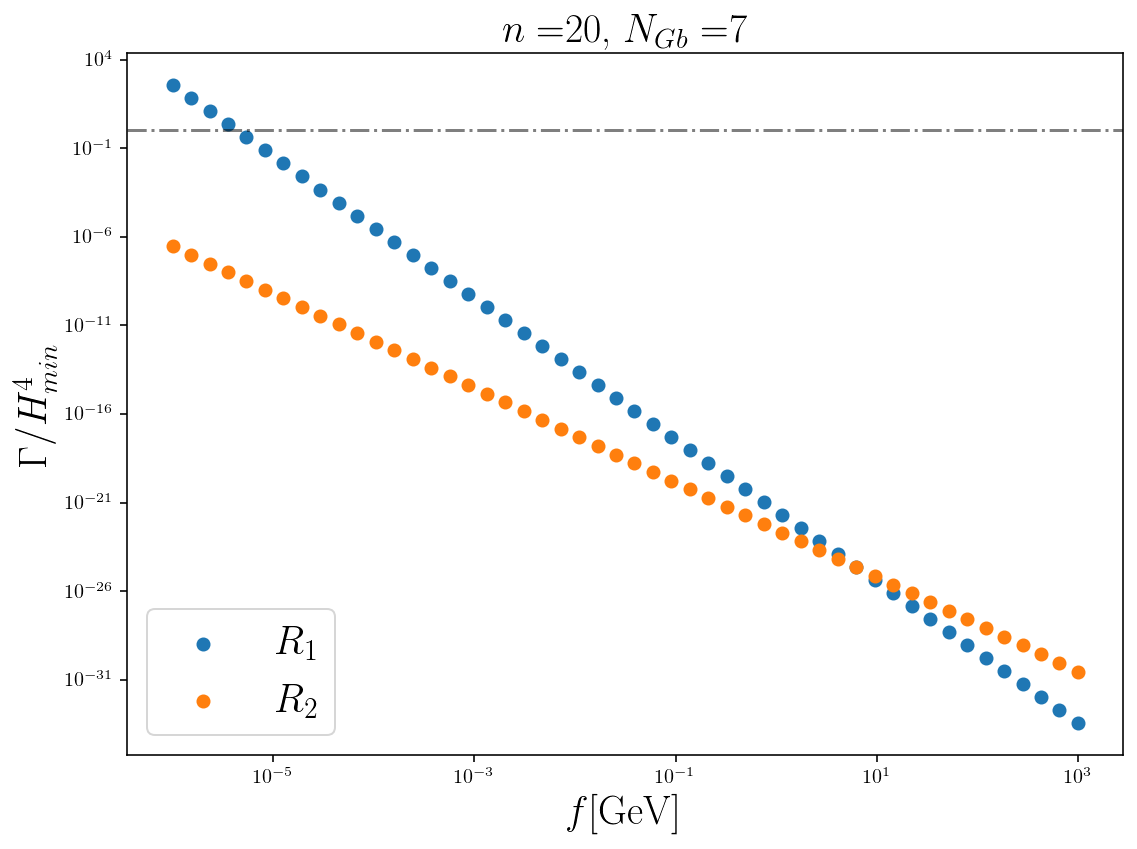

In [4]:
Ngb_val=7
n_val=20
#f_val=1
f_range=np.logspace(-6,3)

results=[]
for f_val in f_range:
    results.append(find_Bubble(Ngb_val,n_val,f_val))

plt.scatter(f_range,np.array(results).T[0],label="$R_1$")
plt.scatter(f_range,np.array(results).T[1],label="$R_2$")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$f$[GeV]",size=label_size)
plt.ylabel("Bubble radius [GeV]$^{-1}$",size=label_size)
plt.legend(prop={'size': label_size})
#plt.xticks(fontsize=thick_size,ticks=n_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$n=$"+str(n_val)+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()



plt.scatter(f_range,np.array(results).T[2])
#plt.yscale("log")
plt.xscale("log")
plt.ylim(np.mean(np.array(results).T[2])-10,np.mean(np.array(results).T[2])+10)
plt.xlabel("$f$[GeV]",size=label_size)
plt.ylabel("$S_4$",size=label_size)
#plt.legend(prop={'size': label_size})
#plt.xticks(fontsize=thick_size,ticks=n_range[0::3])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$n=$"+str(n_val)+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()


plt.scatter(f_range,np.array(results).T[3]/np.array(results).T[5]**2,label="$R_1$")
plt.scatter(f_range,np.array(results).T[4]/np.array(results).T[5]**2,label="$R_2$")
plt.axhline(y=1,linestyle="dashdot",color="k",alpha=.5)
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-40,1e33)
plt.xlabel("$f$[GeV]",size=label_size)
plt.ylabel("$\\Gamma/H_{min}^4$",size=label_size)
plt.legend(prop={'size': label_size})
#plt.xticks(fontsize=thick_size,ticks=n_range[0::4])
#plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$n=$"+str(n_val)+", $N_{Gb}=$"+str(Ngb_val) ,size=label_size)
plt.tight_layout()
plt.show()

# The next two cells are used to scan over parameter space.
## If rerunning this notebook, please skip them and simply load the data frame in the third cell

In [313]:
#Ngb_val=7
n_val=20
#f_val=1
#f_range=np.logspace(-6,-1,500)
f_range=np.linspace(1e-6,1e-1,500)
#N_range=np.arange(8,13,1)
N_range=[8]

results_All=[]
for Ngb_val in N_range:
    for f_val in f_range:
        R0,R0_2, S4, Gamma1, Gamma2,Hmin2= find_Bubble(Ngb_val,n_val,f_val)
        results_All.append({"Ngb":Ngb_val,"n":n_val,"f":f_val,"R0":R0,
                            "R0_2":R0_2, "S4":S4, 
                            "Gamma1":Gamma1, "Gamma2":Gamma2,"Hmin2":Hmin2})


df_results=pd.DataFrame(results_All)



In [314]:
def fun(Tval,modi):
    """Function used to find the nucleation temperature"""
    return df_results.iloc[modi].Gamma1/(df_results.iloc[modi].Hmin2**2+Hubble_radiation(Tval)**2)-1



Tn_list=[]
alpha_list=[]
for modi in range(len(df_results)):
    try:
        Tn=optimize.root_scalar(fun,args=(modi),bracket=(1e-5, 1e16)).root
        Tn_list.append(Tn)
        alpha=df_results.iloc[modi].Hmin2/Hubble_radiation(Tn)
        alpha_list.append(alpha)
    except:
        Tn_list.append(None)
        alpha_list.append(None)
    
df_results["Tnuc"]=Tn_list
df_results["alpha"]=alpha_list
#df_results.to_csv("./SCANS_DS_PT/scan_benchmarks.csv")

In [305]:
df_results=pd.read_csv("./SCANS_DS_PT/scan_benchmarks_1.csv",index_col=[0])

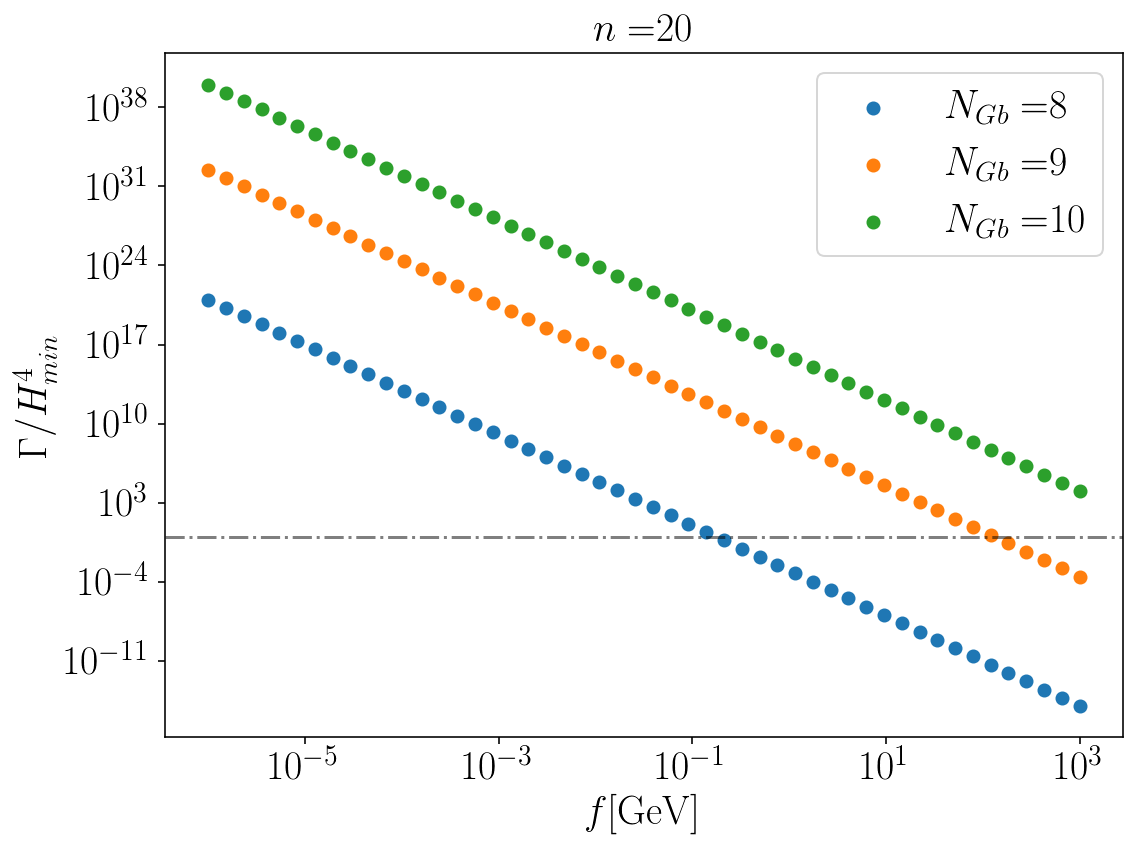

In [307]:

dfplot=df_results[df_results.Ngb==8]
plt.scatter(dfplot.f,dfplot.Gamma1/dfplot.Hmin2**2,label="$N_{Gb}=$"+str(int(dfplot.Ngb.mean())))
dfplot=df_results[df_results.Ngb==9]
plt.scatter(dfplot.f,dfplot.Gamma1/dfplot.Hmin2**2,label="$N_{Gb}=$"+str(int(dfplot.Ngb.mean())))
dfplot=df_results[df_results.Ngb==10]
plt.scatter(dfplot.f,dfplot.Gamma1/dfplot.Hmin2**2,label="$N_{Gb}=$"+str(int(dfplot.Ngb.mean())))
#plt.scatter(f_range,np.array(results).T[4]/np.array(results).T[5]**2,label="$R_2$")
plt.axhline(y=1,linestyle="dashdot",color="k",alpha=.5)
plt.yscale("log")
plt.xscale("log")
#plt.ylim(1e-40,1e33)
plt.xlabel("$f$[GeV]",size=label_size)
plt.ylabel("$\\Gamma/H_{min}^4$",size=label_size)
plt.legend(prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$n=$"+str(int(df_results.n.mean())) ,size=label_size)
plt.tight_layout()
plt.show()

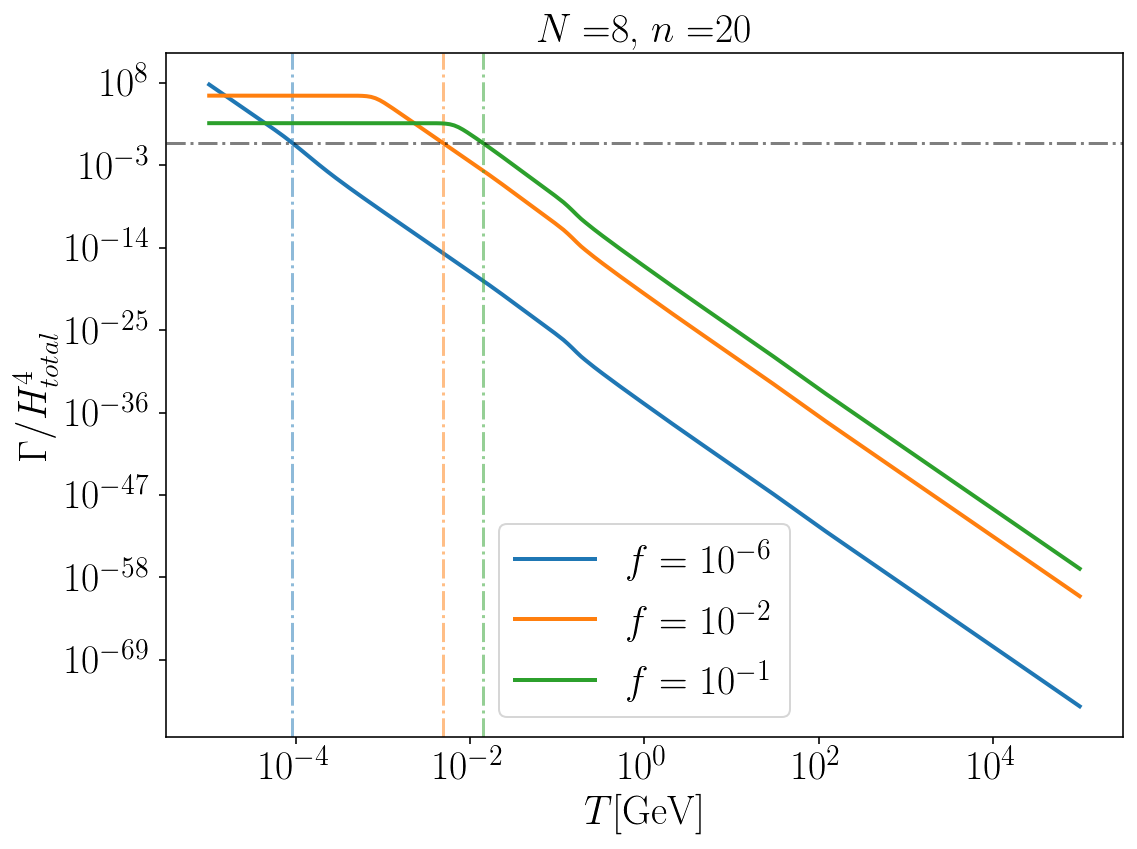

In [311]:
dfplot=df_results[df_results.Ngb==8].sort_values("f",ascending=True)
T_range=np.logspace(-5,5,200)
modi=0
Gamma_full_1=[dfplot.iloc[modi].Gamma1/(dfplot.iloc[modi].Hmin2**2+Hubble_radiation(Tval)**2) for Tval in T_range]
plt.plot(T_range,Gamma_full_1,label="$f=10^{"+str(round(np.log10(dfplot.iloc[modi].f)))+"}$",linewidth=2, markersize=12)
plt.axvline(x=dfplot.iloc[modi].Tnuc,linestyle="dashdot",color="#1f77b4",alpha=.5)


modi=20
Gamma_full_1=[dfplot.iloc[modi].Gamma1/(dfplot.iloc[modi].Hmin2**2+Hubble_radiation(Tval)**2) for Tval in T_range]
plt.plot(T_range,Gamma_full_1,label="$f=10^{"+str(round(np.log10(dfplot.iloc[modi].f)))+"}$",linewidth=2, markersize=12)
plt.axvline(x=dfplot.iloc[modi].Tnuc,linestyle="dashdot",color="#ff7f0e",alpha=.5)


modi=25
Gamma_full_1=[dfplot.iloc[modi].Gamma1/(dfplot.iloc[modi].Hmin2**2+Hubble_radiation(Tval)**2) for Tval in T_range]
plt.plot(T_range,Gamma_full_1,label="$f=10^{"+str(round(np.log10(dfplot.iloc[modi].f)))+"}$",linewidth=2, markersize=12)
plt.axvline(x=dfplot.iloc[modi].Tnuc,linestyle="dashdot",color="#2ca02c",alpha=.5)


plt.axhline(y=1,linestyle="dashdot",color="k",alpha=.5)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$T$[GeV]",size=label_size)
plt.ylabel("$\\Gamma/H_{total}^4$",size=label_size)
plt.legend(loc="best",prop={'size': label_size})
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.grid(True)
plt.title("$N=$"+str(int(dfplot.Ngb.mean()))+", $n=$"+str(int(df_results.n.mean())) ,size=label_size)
plt.tight_layout()
#plt.savefig('./PLOTS/Dark_Sector/nucleation_rates_1.pdf', dpi=300)
plt.show()

In [315]:
#df_results=pd.read_csv("./SCANS_DS_PT/scan_benchmarks_2.csv",index_col=[0])
df=df_results[df_results.alpha>1e-4].sort_values("alpha",ascending=False)
#df=df[df.Tnuc<float(df[df.f==df.f.max()].Tnuc)]



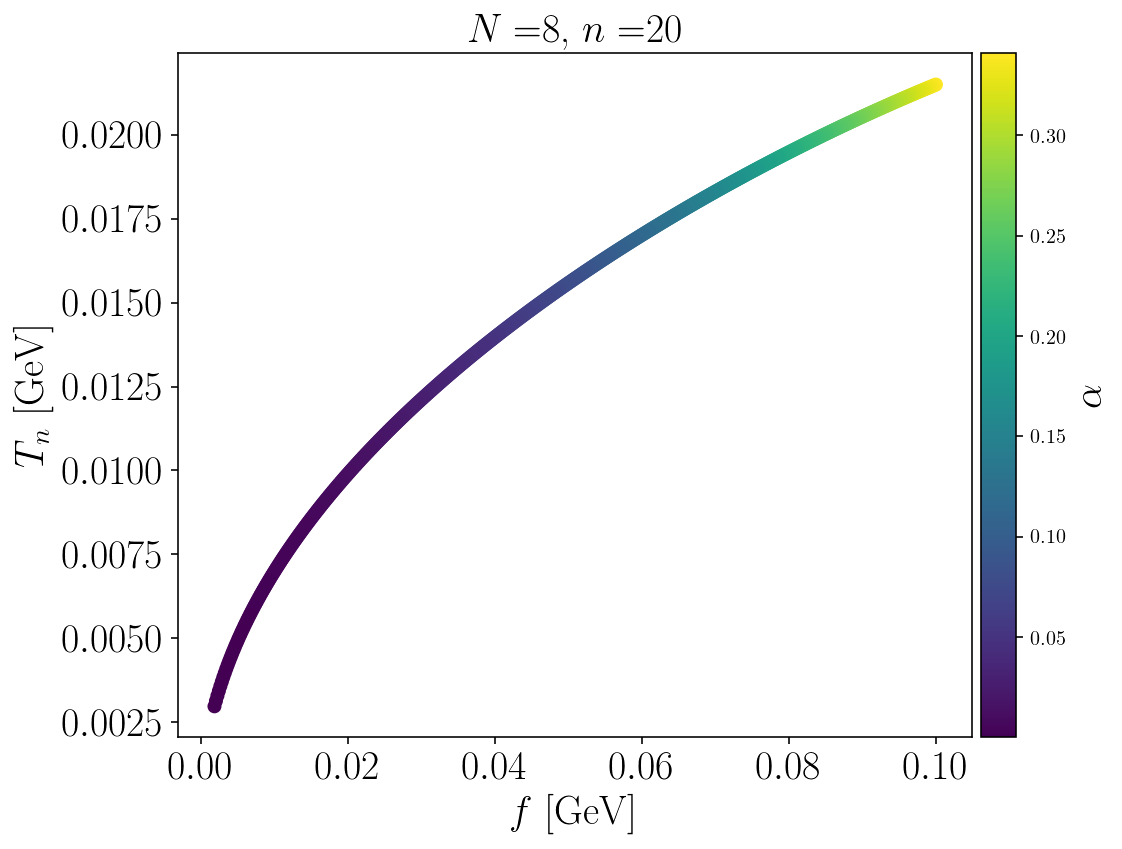

In [317]:
plt.scatter(df.f, df.Tnuc,c=(df.alpha))
plt.colorbar(orientation="vertical",pad=0.01).set_label( label="$\\alpha$", size=label_size, weight='bold')

plt.ylabel("$T_n$ [GeV]",size=label_size)
plt.xlabel("$f$ [GeV]",size=label_size)
plt.xticks(fontsize=thick_size)
plt.yticks(fontsize=thick_size)
#plt.locator_params(axis="x", nbins=6)
plt.title("$N=$"+str(int(df.Ngb.mean()))+", $n=$"+str(int(df.n.mean())) ,size=label_size)
plt.tight_layout()
#plt.savefig('./PLOTS/Dark_Sector/strength_N8.pdf', dpi=300)
plt.show()

In [329]:
fstar=lambda T: 10*Hubble_radiation(T)**.5*.35/(1 + 0.069 + 0.69)

fstar(9)

2.0001621921364736e-16